# EKFSLAM

### SLAM

In robotic mapping and navigation, simultaneous localization and mapping (SLAM) is the computational problem of constructing or updating a map of an unknown environment while simultaneously keeping track of an agent's location within it. While this initially appears to be a chicken-and-egg problem there are several algorithms known for solving it, at least approximately, in tractable time for certain environments. Popular approximate solution methods include the particle filter and extended Kalman filter.

In [1]:
from __future__ import division
import numpy as np
import numpy.linalg as la
import scipy.linalg as sla
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn


### Robot Motion Class
Our 2D robot has a state vector consisting of $(x, y , \theta)^T$. We assume that our robot follows a nonlinear dynamics model implemented with a velocity controller on $v$ and $\omega$. Together $(v,\omega)^T = u$. Thus,
$\mathbf{x}_t = f(\mathbf{x}_{t-1},u)$
where

$$f(\mathbf{x}_{t-1},u) = 
\begin{bmatrix}
x_{t-1} \\
y_{t-1} \\
\theta_{t-1}
\end{bmatrix} + 
\begin{bmatrix}
-\frac{v}{\omega}\sin{\theta_{t-1}} + \frac{v}{\omega}\sin{(\theta_{t-1} + \omega \Delta t)} \\
\frac{v}{\omega}\cos{\theta_{t-1}} - \frac{v}{\omega}\cos{(\theta_{t-1} + \omega \Delta t)} \\
\omega \Delta t
\end{bmatrix}$$

We assume that with our control input $u$ we have associated noise 

$$
\begin{bmatrix}
\hat{v} \\
\hat{\omega}
\end{bmatrix} =
\begin{bmatrix}
v \\
\omega
\end{bmatrix}
+ 
\begin{bmatrix}
\varepsilon_{\alpha_1 v^2 + \alpha_2 \omega^2} \\
\varepsilon_{\alpha_3 v^2 + \alpha_4 \omega^2}
\end{bmatrix}$$

where $\varepsilon_{b^2} \sim \mathcal{N}(0,b^2)$

Note: the velocity motion model doesn't work for straight line motion, this is because we divide by $\omega$.


In [2]:

class VCRobot(object):
    '''
    Class to implement a velocity controlled two-wheeled robot
    
    The robot has state (x, y, theta) 
    The motion model is described in Probabilistic Robotics by Thrun ch. 5d
    '''
    def __init__(self, dt, alpha):
        '''
        member variables:
        dt - time step
        alpha - numpy array (4) describing noise characteristics
        '''
        self.dt = dt
        self.alpha = alpha
    
    def generate_motion(self,v,w,x0):
        '''
        inputs:
        v - numpy array (T) describing velocity
        w - numpy array (T) describing angular velocity
        x0 - numpy array (3) describing initial position
        
        outputs:
        X - numpy array (T,3) describing state at each time step
        '''
        np.random.seed(420)
        dt = self.dt
        alpha = self.alpha
        T = len(v)
        
        X = np.zeros((T+1,3))
        X[0,:] = x0
        
        for t in range(T):
            var1 = alpha[0]*v[t]**2 + alpha[1]*w[t]**2
            var2 = alpha[2]*v[t]**2 + alpha[3]*w[t]**2
            v_hat = v[t] + np.sqrt(var1)*np.random.randn()
            w_hat = w[t] + np.sqrt(var2)*np.random.randn()
            stheta = np.sin(X[t,2])
            ctheta = np.cos(X[t,2])
            sthetap = np.sin(X[t,2] + dt*w_hat)
            cthetap = np.cos(X[t,2] + dt*w_hat)
            
            X[t+1,0] = X[t,0] - v_hat/w_hat*stheta + v_hat/w_hat*sthetap
            X[t+1,1] = X[t,1] + v_hat/w_hat*ctheta - v_hat/w_hat*cthetap
            X[t+1,2] = X[t,2] + w_hat*dt
        
        return X

In [3]:
dt = .1
alpha = np.array([.1, .01, .01, .1])
t = np.arange(0,40.1, dt)
x0 = np.array([-5, -3, np.pi/2])
N_landmarks = 50

Y = np.zeros((N_landmarks,3))
np.random.seed(420)
Y[:,0] = np.random.uniform(low=-20., high=20., size=N_landmarks)
Y[:,1] = np.random.uniform(low=-20., high=20., size=N_landmarks)
Y[:,2] = np.arange(N_landmarks)

R = np.array([[.001, .0, .0],
              [.0, .001, .0],
              [.0, .0, .0001]])

v = 1 + .5*np.cos(.4*np.pi*t)
w = -.2 + 2*np.cos(1.2*np.pi*t)
robot = VCRobot(dt, alpha)
X = robot.generate_motion(v,w,x0)


### Landmarks
As seen in the plot above, we assume there are a number of stationary landmarks from which the robot can take range and bearing measurements. Since these landmarks have fixed position, we can use these measurements to determine our location and bearing. For each landmark $m$ we have an associated $\mathbf{x}_m = (x_m, y_m)^T$ denoting it's position. Since range is a norm and the bearing uses arctangent, this measurement model is inherently nonlinear. We denote this by
$\mathbf{z}_{t,m} = h(\mathbf{x}_{t}, \mathbf{x}_{m}, u)$.
Explicitly,

$$h(\mathbf{x}_t, \mathbf{x}_m, u) = 
\begin{bmatrix}
\sqrt{(x_m - x_t)^2 + (y_m - y_t)^2} \\
\arctan2{\frac{y_m - y_t}{x_m - x_t}} \\
s_m
\end{bmatrix}
$$

Note: In this case and many others, our measurement model does not directly depend on our control input $u$. Also, $s_m$ is the signature associated with a landmark, in this case, we assume known correspondences of objects.

In [4]:
class LandmarkSensor(object):
    '''
    Class to simulate a landmark sensor
    This is a basic range-bearing sensor in 2D
    '''
    
    def __init__(self, Y, R, alpha):
        '''
        member variables:
        Y - numpy array (m, 2) locations of the landmarks
        R - noise covariance associated with range and bearing
        alpha - FOV of the camera in radians
        '''
        self.Y = Y
        self.R = R
        self.alpha = alpha
        
    def simulate(self, X):
        '''
        inputs:
        X - numpy array (T,3) of vehicle state (x,y, theta)
        
        outputs:
        Z - numpy array (T,3*m) of range/bearing/signature measurements
        '''
        Y = self.Y
        m, _ = Y.shape
        
        # Note: this will need to be fixed when we limit the FOV of the robot
        Z = []
        
        for i in range(m):
            z = np.zeros(3)
            z[0] = np.linalg.norm(X[:2] - self.Y[i,:2])
            z[1] = np.arctan2(self.Y[i,1] - X[1], self.Y[i,0] - X[0]) - X[2]
            
            z += np.random.multivariate_normal(np.zeros(3), self.R)
            # wrap relative bearing
            if z[1] > np.pi:
                z[1] = z[1] - 2*np.pi
            if z[1] < -np.pi:
                z[1] = z[1] + 2*np.pi
            z[2] = Y[i,2]
            if np.abs(z[1]) < self.alpha/2:
                Z.append(z)
        
        Z = np.array(Z) 
        return Z

In [5]:
rbsensor = LandmarkSensor(Y, R, np.pi/4)
Z = rbsensor.simulate(X[6,:])
print(Z)

[[ 7.58884008 -0.07019789  0.        ]
 [11.39616078  0.05135259  2.        ]
 [18.60973405  0.2653731  10.        ]
 [ 8.09341943  0.37427285 13.        ]
 [ 2.75071803 -0.0753604  16.        ]
 [ 6.37352955  0.15535694 29.        ]
 [22.20860664 -0.13831892 30.        ]
 [20.98022904 -0.2865478  41.        ]
 [14.30485537 -0.250783   46.        ]]


In [6]:
class EKFSLAM(object):
    '''
    Class to implement an Extended Kalman Filter SLAM
    for a system with noise on control inputs
    '''
    
    def __init__(self,x0,R):
        '''
        Class Variables:
        f(x,u) - function handle nonlinear state transition
        h(x,u) - function handle nonlinear measurement model
        F(x,u) - function handle Jacobian of state w/ respect to state
        G(x,u) - function handle Jacobian of state w/ respect to input
        H(x,u) - function handle Jacobian of measurement w/ respect to state
        Q(u) - function handle Covariance of input
        R - numpy matrix (mxm) sensor noise covariance
        '''
        inf = 1e15
        self.mu = np.zeros(3*N_landmarks + 3)
        self.mu[0:3] = x0
        self.cov = np.matrix(inf*np.eye(3*N_landmarks + 3))
        self.cov[0,0] = 0
        self.cov[1,1] = 0
        self.cov[2,2] = 0
        self.seen = N_landmarks*[False]

        self.R = R
        
    def f(self, x, u):
        xp = np.zeros_like(x)
        v = u[0]
        w = u[1]
        stheta = np.sin(x[2])
        ctheta = np.cos(x[2])
        sthetap = np.sin(x[2] + dt*w)
        cthetap = np.cos(x[2] + dt*w)
        xp[0] = x[0] - v/w*stheta + v/w*sthetap
        xp[1] = x[1] + v/w*ctheta - v/w*cthetap
        xp[2] = x[2] + w*dt
        return xp 
    
    def h(self,x,y,u):
        zp = np.zeros(3)
    
        zp[0] = np.linalg.norm(x[0:2] - y[0:2])
        zp[1] = np.arctan2(y[1] - x[1], y[0] - x[0]) - x[2]
        if zp[1] > np.pi:
            zp[1] -= 2*np.pi
        elif zp[1] < -np.pi:
            zp[1] += 2*np.pi
        zp[2] = y[2]
        return zp
    
    def F(self,x,u):
        n = x.shape[0]
        v = u[0]
        w = u[1]
        stheta = np.sin(x[2])
        ctheta = np.cos(x[2])
        sthetap = np.sin(x[2] + dt*w)
        cthetap = np.cos(x[2] + dt*w)
    
        F = np.matrix(np.zeros((n,n)))
        F[0,2] = -v/w*ctheta + v/w*cthetap
        F[1,2] = -v/w*stheta + v/w*sthetap
        return F
    
    def G(self,x,u):
        n = x.shape[0]
        k = u.shape[0]
        v = u[0]
        w = u[1]
        stheta = np.sin(x[2])
        ctheta = np.cos(x[2])
        sthetap = np.sin(x[2] + dt*w)
        cthetap = np.cos(x[2] + dt*w)
    
        G = np.matrix(np.zeros((n,k)))
        G[0,0] = (-stheta + sthetap)/w
        G[0,1] = v*(stheta-sthetap)/(w**2) + v*(ctheta*dt)/w
        G[1,0] = (ctheta - cthetap)/w
        G[1,1] = -v*(ctheta - cthetap)/(w**2) + v*(stheta*dt)/w
        G[2,1] = dt
        return G

    def H(self,x,y,u):
        H = np.matrix(np.zeros((3,6)))
        dx = y[0] - x[0]
        dy = y[1] - x[1]
        q = (y[0] - x[0])**2 + (y[1] - x[1])**2
        sq = np.sqrt(q)
        H[0,0] = -(dx)/sq
        H[0,1] = -(dy)/sq
        H[0,2] = 0
        H[0,3] = dx/sq
        H[0,4] = dy/sq
        H[0,5] = 0
        H[1,0] = dy/q
        H[1,1] = -dx/q
        H[1,2] = -1
        H[1,3] = -dy/q
        H[1,4] = dx/q
        H[1,5] = 0
        H[2,5] = 1
        return H

    def Q(self,u):
        k = u.shape[0]
        v = u[0]
        w = u[1]
        Q = np.matrix(np.zeros((k,k)))
        Q[0,0] = alpha[0]*v**2 + alpha[1]*w**2
        Q[1,1] = alpha[2]*v**2 + alpha[3]*w**2
        return Q
    
    def filter(self,z,u):
        '''
        z - (n_landmarks_seen x 3)
        u - control input
        Filters the the slam problem over 1 time step
        '''
        # Prediction
        self.mu[0:3] = self.f(self.mu[0:3],u)
        Fx = np.matrix(np.zeros((3,3*N_landmarks + 3)))
        Fx[0,0] = 1
        Fx[1,1] = 1
        Fx[2,2] = 1
        F = np.matrix(np.eye(3*N_landmarks+3))+Fx.T*self.F(self.mu[0:3],u)*Fx
        G = 5*self.G(self.mu[0:3],u) 

        self.cov = F*self.cov*F.T + Fx.T*G*self.Q(u)*G.T*Fx  #Scaling up the input covariance
        
        if z.size == 0:
            return np.copy(self.mu), np.copy(self.cov)
        
        l = z[:,2]
        for j,s in enumerate(l):
            #Measurement Update
            s = int(s)
            if self.seen[s] == False:
                self.mu[3*(s+1)] = self.mu[0] + z[j, 0]*np.cos(z[j,1] + self.mu[2])
                self.mu[3*(s+1) + 1] = self.mu[1] + z[j, 0]*np.sin(z[j,1] + self.mu[2])
                self.mu[3*(s+1) + 2] = s
                self.seen[s] = True
                
            y = self.mu[3*(s+1):3*(s+1)+3]
            z_hat = self.h(self.mu[:3],y,u)
            Fxj = np.matrix(np.zeros((6, 3*N_landmarks + 3)))
            Fxj[0,0] = 1
            Fxj[1,1] = 1
            Fxj[2,2] = 1
            Fxj[3,3*(s+1)] = 1
            Fxj[4, 3*(s+1)+1] = 1
            Fxj[5, 3*(s+1)+2] = 1
            H = self.H(self.mu[:3],y,u)*Fxj
            
            K = self.cov*H.T*(la.inv(H*self.cov*H.T + self.R))
            
            innovation = z[j] - z_hat
            if innovation[1] > np.pi:
                innovation[1] -= 2*np.pi
            elif innovation[1] < -np.pi:
                innovation += 2*np.pi
            innovation = np.matrix(innovation).T
            update = np.array(K*innovation).flatten()
            self.mu += update
            self.cov = (np.eye(3*N_landmarks+3) - K*H).dot(self.cov)
            
        return np.copy(self.mu), np.copy(self.cov)

In [7]:
U = np.column_stack([v, w])
x0 = np.array([-5, -3, np.pi/2])
x_hat = x0
ekf = EKFSLAM(x0,R)


In [8]:
X_hat = []
Cov_hat = []
for t,u in enumerate(U):
    z = rbsensor.simulate(X[t+1])
    x_hat, Cov = ekf.filter(z,u)
    X_hat.append(x_hat)
    Cov_hat.append(Cov)  

In [9]:
X_hat = np.array(X_hat)

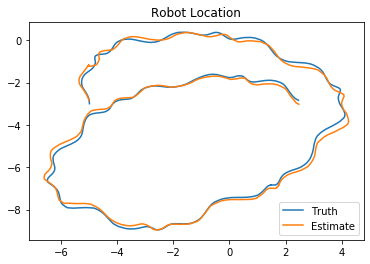

In [10]:
plt.plot(X[:,0],X[:,1],label="Truth")
plt.plot(X_hat[:,0], X_hat[:,1],label="Estimate")
plt.title("Robot Location")
plt.legend()
plt.show()

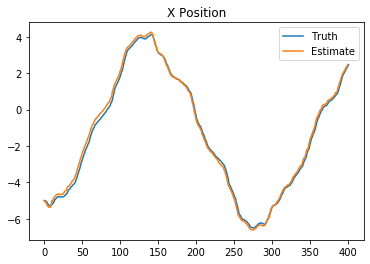

In [11]:
plt.plot(X[:,0],label="Truth")
plt.plot(X_hat[:,0],label="Estimate")
plt.title("X Position")
plt.legend()
plt.show()

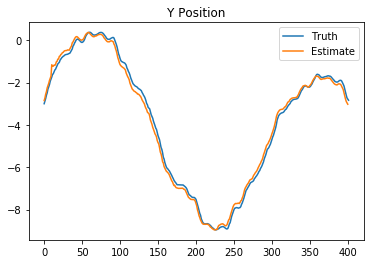

In [12]:
plt.plot(X[:,1],label="Truth")
plt.plot(X_hat[:,1],label="Estimate")
plt.title("Y Position")
plt.legend()
plt.show()

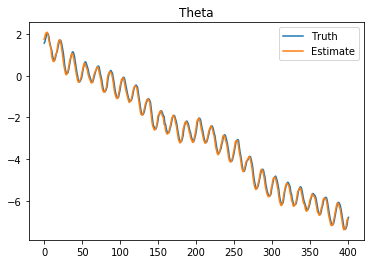

In [13]:
plt.plot(X[:,2],label="Truth")
plt.plot(X_hat[:,2],label="Estimate")
plt.title("Theta")
plt.legend()
plt.show()